Forecasting Non-Sationary Time Series

We will forecast 1 year’s quarterly EPS, meaning that we must forecast four timesteps into the future, since there are four quarters in a year. The dataset covers the period between 1960 and 1980

In [1]:
import pandas as pd
df= pd.read_csv(r"C:\Users\user\Downloads\jj.csv")
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


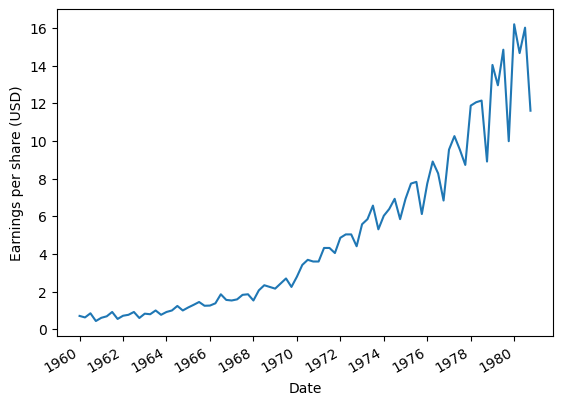

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel("Date")
ax.set_ylabel("Earnings per share (USD)")

plt.xticks(np.arange(0,81,8), ['1960', '1962', '1964', '1966', '1968', '1970', '1972', '1974', '1976', '1978', '1980'])

fig.autofmt_xdate()
plt.show()

In [3]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df["data"])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


In [4]:
#apply frst order differencing

eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.407409763638043
p-value: 0.9088542416911309


The series is not stationary yet even after first order differencing

In [5]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-vale: {ad_fuller_result[1]}')

ADF Statistic: -3.5851628747931517
p-vale: 0.006051099869603741


Our order of integration is thus 2 (d=2)

In [12]:
from typing import Union
from tqdm import tqdm_notebook

from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list:list, d:int) -> pd.DataFrame:
    results =[] #empty list to store the order (p,q)  and the corresponding AIC as a tuple
    for order in tqdm_notebook(order_list): #progress bar, iterate over each unique (p,q) combination
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing= False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic]) #append the (p,q) and the corresponding AIC as a tuple to the results list

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df 


In [13]:
from itertools import product

ps = range(0,4,1) 
qs= range(0,4,1)
d=2

order_list = list(product(ps,qs)) #generate a list containing all unique combinations of (p,q)

In [15]:
import warnings 
warnings.filterwarnings("ignore")

train = df.data[:-4] #all data except last 4 entries

result_df = optimize_ARIMA(train, order_list, d)
result_df 

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.273665
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430678
4,"(0, 3)",194.654716
5,"(0, 2)",209.274515
6,"(2, 3)",220.666885
7,"(1, 3)",228.267839
8,"(1, 2)",228.935907
9,"(2, 2)",229.974675


An ARIMA (3,2,3) seems to be the most suitable. Let's fit the model and look at the residuals

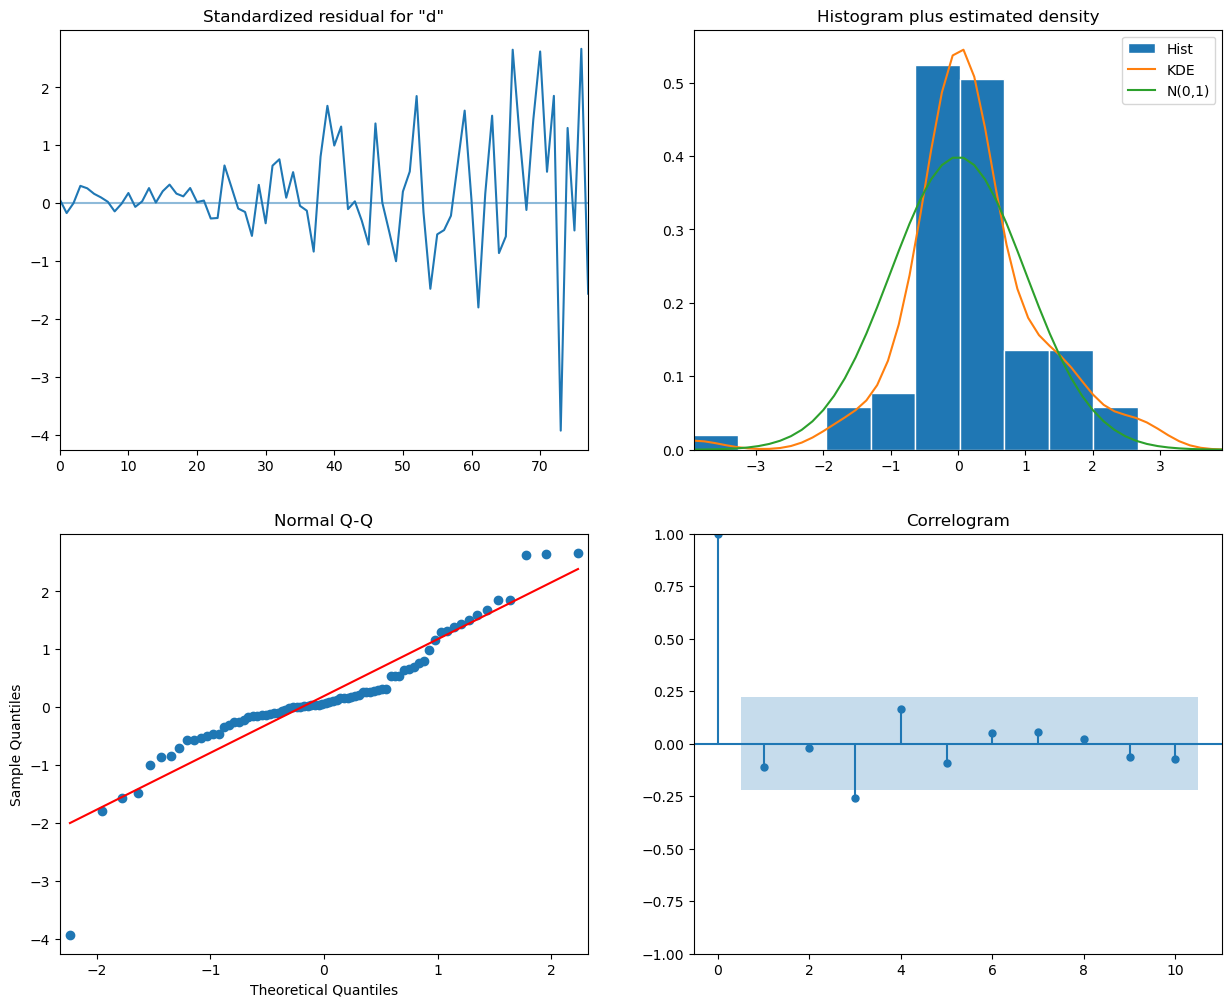

In [17]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

1. Top left plot, no trend but variance is not constant.
2. Top right,and bottom left, the distribution and the Q-Q plots shows the residual's distribution is close to a normal one. 
3. Bottom right fromt he corelogram, there  seems to be a significant coefficient at lag 3, but since it is not preceded by any significant autocorrelation coefficients we assume it is due to chance.
4. We apply Ljung-Box test for quantitative analysis of the residuals. If the p-values are above 0.005 then we cannot reject the null hypothesis, and thus the residuals are not correlated.   

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

lb_test = acorr_ljungbox(residuals, lags= np.arange(1, 11,1), return_df=True)

lb_test

,lb_stat,lb_pvalue
1,1.583947,0.208193
2,1.585094,0.452690
3,7.242882,0.064546
4,9.166799,0.057063
5,9.780272,0.081706
6,10.009054,0.124271
7,10.258275,0.174404
8,10.294646,0.244952
9,10.636937,0.301418
10,11.097156,0.349999


Having all the p-values above 0.05, we reject the null hypothesis, since they are not correlated, just like white noise. 

Having passed all the tests, our ARIMA model (3,2,3), can be used for forecasting. Our testing set is the 4 quarterly EPS of 1980, meaning that we’ll take the EPS of the first quarter of
1979 and use it as a forecast for the EPS of the first quarter of 1980. Then the EPS of
the second quarter of 1979 will be used as a forecast for the EPS of the second quarter
of 1980, and so on. 

We need a benchmark, or a baseline model, when modeling to determine whether the model we develop is better than a naive method. The performance of a model must always be assessed relative to a baseline model

In [28]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values 

In [30]:
ARIMA_pred = model_fit.get_prediction(80,83).predicted_mean 

test['ARIMA_pred'] = ARIMA_pred  #assign it to the columns 
test 

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858615
81,1980-04-01,14.67,12.96,14.380478
82,1980-07-02,16.02,14.85,16.371732
83,1980-10-01,11.61,9.99,11.683178


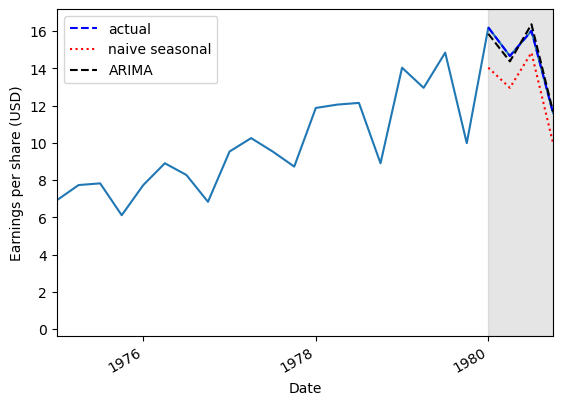

In [32]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b--', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA')

ax.set_xlabel ('Date')
ax.set_ylabel ('Earnings per share (USD)')
ax.axvspan(80,83, color='grey', alpha=0.2)

ax.legend()

plt.xticks(np.arange(0,81,8), ['1960', '1962', '1964', '1966', '1968', '1970', '1972', '1974', '1976', '1978', '1980'])
ax.set_xlim(60,83)

fig.autofmt_xdate()
plt.show()

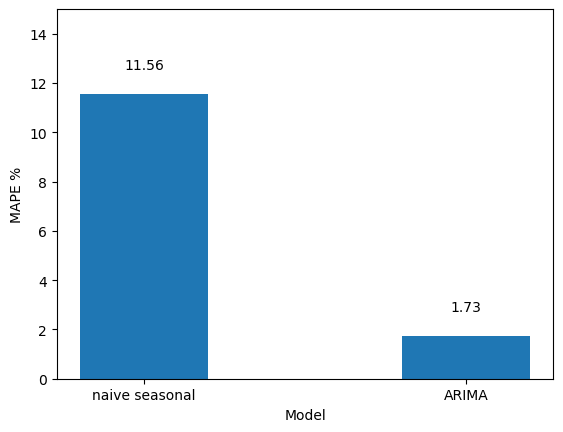

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

fig, ax = plt.subplots()

x= ['naive seasonal', 'ARIMA']
y =[mape_naive_seasonal, mape_ARIMA]

ax.bar(x,y, width=0.4)

ax.set_xlabel('Model')
ax.set_ylabel('MAPE %')
ax.set_ylim(0,15)

for index, value in enumerate(y):
    plt.text(x=index, y=value+1, s=str(round(value,2)), ha='center')


plt.show()

Our predictions are roughly 1.73% off from the actual values. The ARIMA(3,2,3) takes the day